<a href="https://colab.research.google.com/github/napolitanodst/Apprenticeship-log/blob/Apprenticeship-Code/Geo_CNN_AltroMetodo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt
import pickle
import zipfile
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [2]:
#Importing delle immagini del dataset
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/dataset.zip', 'r') 
zip_ref.extractall('/tmp') 
zip_ref.close()

In [3]:
Dir= '/tmp/dataset'
Classes= ['Metamorfiche','Sedimentarie', 'Vulcaniche']

In [4]:
data = []
for category in Classes:
    folder = os.path.join(Dir, category)
    label = Classes.index(category)
    for img in os.listdir(folder):
        percorso = os.path.join(folder, img)
        array = cv2.imread(percorso)
        array= cv2.resize(array,(384,306))
        data.append([array,label])
random.shuffle(data)     

In [5]:
#Creazione Dataset
Train_data = []
Train_labels = []
for features, labels in data:
  Train_data.append(features)
  Train_labels.append(labels)

Data = np.array(Train_data)
Labels = np.array(Train_labels)

In [6]:
#Creazione Test Dataset
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/test.zip', 'r') 
zip_ref.extractall('/tmp') 
zip_ref.close()

cartella = '/tmp/test'
Test= []
for category in Classes:
    folder2 = os.path.join(cartella, category)
    label = Classes.index(category)
    for img in os.listdir(folder2):
        percorso2 = os.path.join(folder2, img)
        array2 = cv2.imread(percorso2)
        array2= cv2.resize(array2,(384,306))
        Test.append([array2,label])
random.shuffle(Test)     

Test_data = []
Test_labels = []
for features, labels in Test:
  Test_data.append(features)
  Test_labels.append(labels)

Test = np.array(Test_data)
Test_Labels = np.array(Test_labels)


In [7]:
#Modello
model = tf.keras.models.Sequential(
    [
    tf.keras.layers.Rescaling(1./255),   
    tf.keras.layers.Conv2D(16, 4, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(7, 4, activation ='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(len(Classes), activation="softmax")
    ]
)

In [8]:
#Training
training=model.compile(
             optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics=["accuracy"]
)

In [9]:
#Early Stopping per monitorare la validation accuracy
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy',patience=10, mode="auto")

In [10]:
#Fitting
history = model.fit(
                    Data,
                    Labels,
                    validation_split = 0.3,
                    epochs=100,
                    callbacks= [early_stopping]
)

Epoch 1/100
5/5 [==============================] - 11s 257ms/step - loss: 4.4439 - accuracy: 0.3946 - val_loss: 1.4840 - val_accuracy: 0.2698
Epoch 2/100
5/5 [==============================] - 0s 66ms/step - loss: 1.0289 - accuracy: 0.5170 - val_loss: 0.9571 - val_accuracy: 0.5397
Epoch 3/100
5/5 [==============================] - 0s 70ms/step - loss: 0.8371 - accuracy: 0.7143 - val_loss: 0.7885 - val_accuracy: 0.6190
Epoch 4/100
5/5 [==============================] - 0s 54ms/step - loss: 0.5870 - accuracy: 0.7755 - val_loss: 0.5705 - val_accuracy: 0.7143
Epoch 5/100
5/5 [==============================] - 0s 54ms/step - loss: 0.4389 - accuracy: 0.8095 - val_loss: 0.8083 - val_accuracy: 0.5714
Epoch 6/100
5/5 [==============================] - 0s 51ms/step - loss: 0.3950 - accuracy: 0.8776 - val_loss: 0.7417 - val_accuracy: 0.7302
Epoch 7/100
5/5 [==============================] - 0s 53ms/step - loss: 0.2621 - accuracy: 0.9592 - val_loss: 0.5714 - val_accuracy: 0.8095
Epoch 8/100
5/5 [=

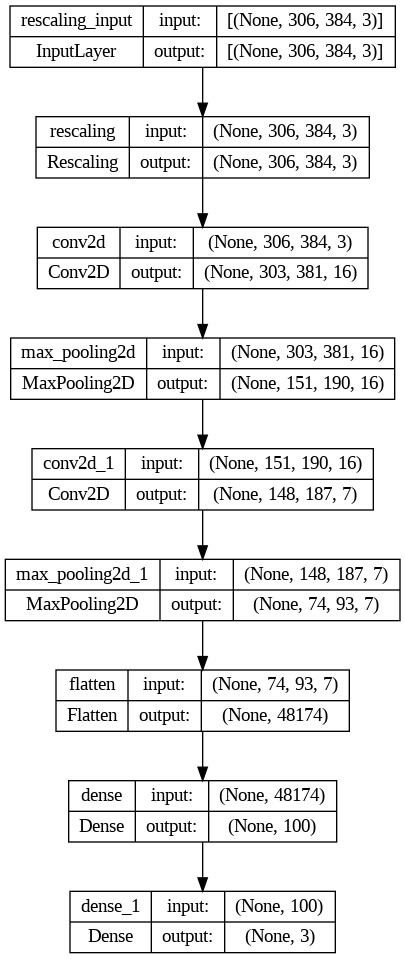

In [11]:
keras.utils.plot_model(model, show_shapes=True)

In [12]:
#Evaluation con test dataset
model.evaluate(Test, Test_Labels)

1/1 [==============================] - 0s 228ms/step - loss: 4.6640 - accuracy: 0.3793


[4.6639723777771, 0.37931033968925476]

<Axes: >

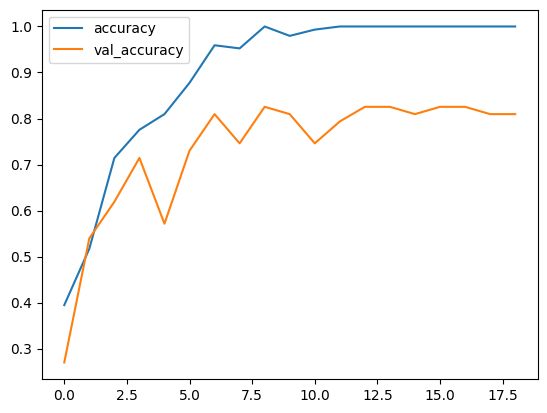

In [13]:
#Plot di accuracy e validation accuracy
pd.DataFrame(history.history)[["accuracy","val_accuracy"]].plot()

<Axes: >

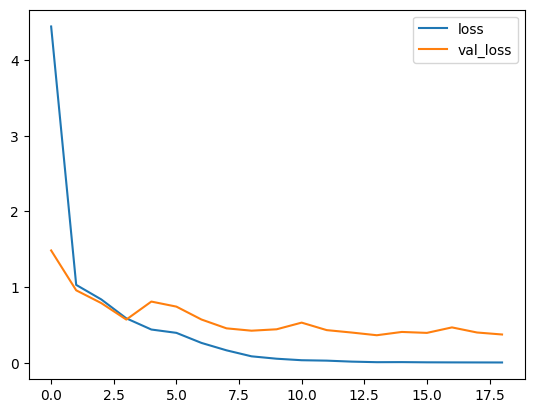

In [14]:
#Plot loss e validation loss
pd.DataFrame(history.history)[["loss", "val_loss"]].plot()

In [15]:
#Confusion Matrix
predict= model.predict(Data)
predict1 = tf.argmax(predict, axis=1)
confusion_matrix(Labels,predict1)

7/7 [==============================] - 0s 32ms/step


array([[60,  1,  7],
       [ 0, 76,  0],
       [ 3,  1, 62]])

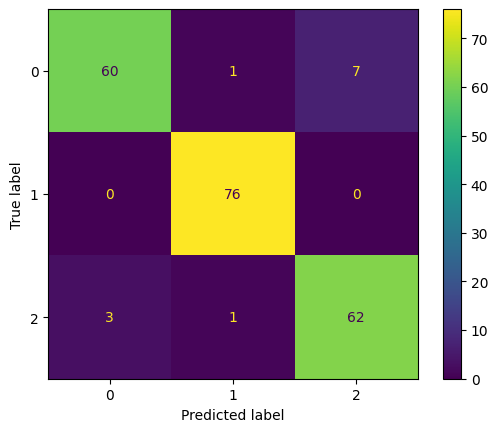

In [16]:
ConfusionMatrixDisplay.from_predictions(Labels, predict1)

In [19]:
def plot_wrong_labeled_data(X_test, y_true, y_preds, label_to_check, wrong_label = None):
  # Search for the wrong data
  wrongs = []
  for i in range(len(X_test)):
    true_label_found = y_true[i] == label_to_check
    wrong_label_found = wrong_label != None and y_preds[i] == wrong_label
    wrong_preds_label = wrong_label == None and y_preds[i] != label_to_check
    if true_label_found and (wrong_label_found or wrong_preds_label):
      wrongs.append((X_test[i], y_preds[i]))
  
  # Shuffle result
  random.shuffle(wrongs)

  # Plot result
  plt.figure(figsize=(10,10))
  for i in range(7):
    wrong = wrongs[i]
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(wrong[0], cmap=plt.cm.binary)
    plt.text(14, 32, wrong[1].numpy())
  plt.show()


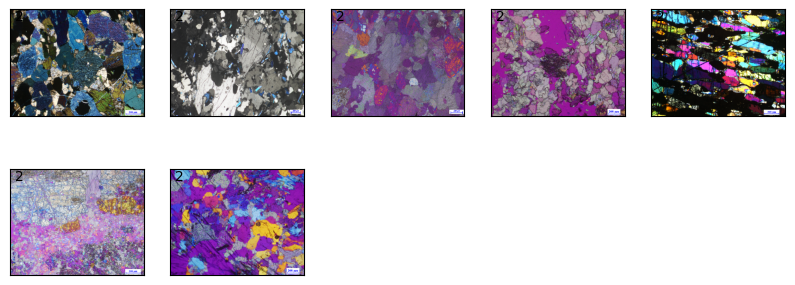

In [20]:
#Plot immagini con wrong label
plot_wrong_labeled_data(Data, Labels, predict1,0,2)